## DCGANs on MNIST data
You can run this notebook on google colab.

<div align="center"><a href="https://colab.research.google.com/github/vstark21/DCGANs/blob/master/DCGAN_on_digits.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a></div>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import time

Creating functions - 
* `generator_model` - returns a model to generate images.
* `discriminator_model` - returns a model to discriminate original images and generated images.
* `generator_loss` - loss to optimize generator model so that it produces images like original images.
* `discriminator_loss` - loss to optimize discriminator model so that it discriminates original images and generated images correctly.

In [2]:
def generator_model():

    model = keras.Sequential()

    model.add(keras.layers.Dense(7*7*256, input_shape=[100, ]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())

    model.add(keras.layers.Reshape((7, 7, 256)))

    model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())

    model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU()),

    model.add(keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", activation="tanh"))

    return model

def discriminator_model():

    model = keras.Sequential([
                             keras.layers.Conv2D(64, (5, 5), strides=(2, 2), input_shape=(28, 28, 1), padding="same"),
                               keras.layers.Dropout(0.3),
                             keras.layers.LeakyReLU(),

                             keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
                             keras.layers.Dropout(0.3),
                             keras.layers.LeakyReLU(),
                              
                             keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same"),
                             keras.layers.Dropout(0.3),
                             keras.layers.LeakyReLU(),

                             keras.layers.Flatten(),
                             keras.layers.Dense(1, activation="sigmoid")
    ])

    return model

def generator_loss(generated_output):

    cross_entropy = keras.losses.BinaryCrossentropy()
    loss = cross_entropy(tf.ones_like(generated_output), generated_output)
    
    return loss


def discriminator_loss(original_output, generated_output):

    cross_entropy = keras.losses.BinaryCrossentropy()
    
    real_loss =  cross_entropy(tf.ones_like(original_output), original_output)
    gen_loss = cross_entropy(tf.zeros_like(generated_output), generated_output)

    total_loss = real_loss + gen_loss

    return total_loss

    

Loading data from `tf.keras.datasets.mnist` then reshaping, normalizing them and slicing them into minibatches.

**NOTE :** 
> All the training images should be normalized to [-1, 1] beacuse all the discminator's inputs must have values which are in same range as generator model's output is computed using *tanh* so it returns values in range [-1, 1].

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Creating a function `generate_and_save_images` so that we can save images after each epoch and creating a constant `TEST_INPUT` so that we can always use it to generate images to save.

In [6]:
TEST_INPUT = tf.random.normal((16, 100))
def generate_and_save_images(model, epoch, test_input):

    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Creating a function `train_step` to train our models.

In [ ]:
@tf.function
def train_step(batch):
    
    noise = tf.random.normal([BATCH_SIZE, GEN_INPUT_DIMS])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(noise, training=True)
            
        original_output = discriminator(batch, training=True)
        generated_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(original_output, generated_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


Creating a generator model to test whether its output matches our required output.

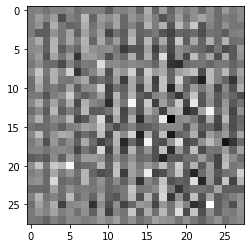

In [4]:
gen_test = generator_model()
image = gen_test(tf.random.normal([3, 100]))
plt.imshow(image[1, :, :, 0] * 127.5 + 127.5, cmap="gray")

EPOCHS = 100
GEN_INPUT_DIMS = 100

Creating models and optimizers and training them using **mini-batch Gradient Descent**

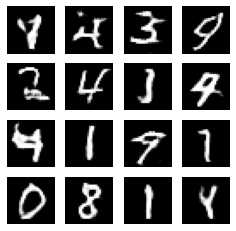

Epoch 99 took 45.63103413581848 with gen_loss of 0.9433663487434387 and disc_loss of 1.323568344116211


In [8]:
generator = generator_model()
discriminator = discriminator_model()
generator_optimizer = keras.optimizers.Adam(0.0001)
discriminator_optimizer = keras.optimizers.Adam(0.0001)

for epoch in range(EPOCHS):

    print(f"In epoch : {epoch}")
    epoch_start = time.time()

    for batch in train_dataset:

        gen_loss, disc_loss = train_step(batch)
        

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch, TEST_INPUT)
    print(f"Epoch {epoch} took {time.time() - epoch_start} with gen_loss of {gen_loss} and disc_loss of {disc_loss}")

Creating a *gif* using all the images generated.

In [9]:
import os, imageio

files = os.listdir()

images = []

for filename in files:

    if filename[-3:] == "png":
        images.append(imageio.imread(filename))

imageio.mimsave("Generating_Digits.gif", images)